# Stock Price Prediction avec LSTM

**LSTM (Long Short-Term Memory)** est une architecture de réseau neuronal récurrent artificiel (RNN) utilisée dans le deep learning.
Les LSTM sont largement utilisés pour les problèmes de prédiction de séquences et se sont avérés extrêmement efficaces. La raison pour laquelle ils fonctionnent si bien, c’est parce que LSTM est en mesure de stocker des informations passées qui est important, et oublier l’information qui n’est pas.

## Importer les libraries

In [1]:
#pip install yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.models import load_model
%matplotlib inline
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Historique des cours de  Microsoft, AMazon et Google

Historique des prix par jour sur les dix dernières années en utilisant Yahoo's Finance API. 

In [2]:
def get_data(symbol):
    tickerData = yf.Ticker(symbol)
    data = tickerData.history(period='1d', start='2010-10-1', end="2020-10-2")
    data['companies'] = symbol
    data.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
    return data



In [3]:
msft = get_data("MSFT")
amzn = get_data("AMZN")
goog = get_data("GOOG")

In [5]:
amzn.tail()

,Open,High,Low,Close,Volume,companies
Date,,,,,,
2020-09-25,3054.86,3101.54,2999.00,3095.13,4615200,AMZN
2020-09-28,3148.85,3175.04,3117.17,3174.05,4224200,AMZN
2020-09-29,3175.39,3188.26,3132.54,3144.88,3495800,AMZN
2020-09-30,3141.14,3212.88,3133.99,3148.73,4883400,AMZN
2020-10-01,3208.00,3224.00,3172.00,3221.26,4971900,AMZN


##  Concaténer les 3 Dataframes

Nous avons 7557 observations et 6 features

In [5]:
company_list = [msft, amzn, goog]
    
df_concat = pd.concat(company_list, axis=0)
    
df_concat.head()

,Open,High,Low,Close,Volume,companies
Date,,,,,,
2010-09-30,19.50,19.67,19.30,19.40,61262700,MSFT
2010-10-01,19.62,19.66,19.25,19.32,62672300,MSFT
2010-10-04,18.98,19.01,18.84,18.94,98143400,MSFT
2010-10-05,19.06,19.37,18.94,19.29,78152900,MSFT
2010-10-06,19.27,19.44,19.12,19.36,50489700,MSFT


In [6]:
df_concat.companies.unique()

array(['MSFT', 'AMZN', 'GOOG'], dtype=object)

## Split data 

1. Nous choisissons uniquement closing prices puis nous les convertissons en un array. 

2. Split des données training dataset(80%) et test 

3. Nous utilisons MinMaxScaler pour avoir des valeurs comprises entre 0 et 1.  

4. Créons un data training composé des 60 derniers jours, que nous utiliserons à la fin  pour prédire la valeur du prix de clôture 61e.
5. Reshape les données pour qu’elles soient tridimensionnelles afin de les mettre dans le modèle LSTM

In [7]:
def split_data(df, symbol):
    data = df.filter(['Close']).loc[df['companies']== symbol]
    dataset = data.values.reshape(-1, 1)
    training_data_len = int(np.ceil(len(dataset) * .8 ))
    print(f'Longueur du data: {training_data_len}')
    print('================================================')
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data= scaler.fit_transform(dataset)
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    return x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len

## Construction de modèle LSTM 

1. **ModelCheckpoint** va enregistrer les poids des modèles à la fin de chaque époque
2. **CSVLogger** va sauvegarder nos RMSE
3. Splittons une partie des données tranining en validation
4. plot history RMSE
5. VIsualization des valeurs actuelles vs Prédictions

In [8]:
def algo_lstm(x_train, y_train, x_test, y_test, scaler, symbol):
    x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len = split_data(df_concat, symbol)
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences= False))
    model.add(Dense(25))
    model.add(Dense(1))
    checkpointer = ModelCheckpoint(filepath=f"{symbol}_model.h5", verbose=1, save_best_only=True)
    csv_logger = CSVLogger(f"{symbol}_history_loss.log")
    callbacks=[csv_logger, checkpointer]
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(x_train, y_train, batch_size=16, epochs=50, validation_split=0.1, callbacks=[callbacks])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print('================================================')
    print(f'RMSE: {rmse}')
    print('================================================')
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16,8))
    plt.title('Prédictions vs. valeurs réeles')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Valeurs actuelles', 'Prédictions'], loc='lower right')
    plt.show()
    print('================================================')
    print(valid)
    

    return model



# LSTM Microsft

In [9]:
 x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len = split_data(df_concat, "MSFT")

Longueur du data: 2016


Longueur du data: 2016
Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: 2.3711e-04
Epoch 00001: val_loss improved from inf to 0.00014, saving model to MSFT_model.h5
110/110 [==============================] - 14s 132ms/step - loss: 2.3711e-04 - val_loss: 1.4415e-04
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: 3.2928e-05
Epoch 00002: val_loss did not improve from 0.00014
110/110 [==============================] - 10s 95ms/step - loss: 3.2928e-05 - val_loss: 2.1449e-04
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: 3.0391e-05
Epoch 00003: val_loss improved from 0.00014 to 0.00014, saving model to MSFT_model.h5
110/110 [==============================] - 11s 98ms/step - loss: 3.0391e-05 - val_loss: 1.3861e-04
Epoch 4/50
110/110 [==============================] - ETA: 0s - loss: 3.2950e-05
Epoch 00004: val_loss did not improve from 0.00014
110/110 [==============================] - 10s 87ms/step - loss: 3.2950e-05 - val_los

Epoch 34/50
110/110 [==============================] - ETA: 0s - loss: 1.1478e-05- ETA: 1s
Epoch 00034: val_loss improved from 0.00004 to 0.00004, saving model to MSFT_model.h5
110/110 [==============================] - 9s 85ms/step - loss: 1.1478e-05 - val_loss: 3.8082e-05
Epoch 35/50
110/110 [==============================] - ETA: 0s - loss: 1.0702e-05
Epoch 00035: val_loss did not improve from 0.00004
110/110 [==============================] - 10s 91ms/step - loss: 1.0702e-05 - val_loss: 4.7389e-05
Epoch 36/50
110/110 [==============================] - ETA: 0s - loss: 1.1783e-05
Epoch 00036: val_loss improved from 0.00004 to 0.00004, saving model to MSFT_model.h5
110/110 [==============================] - 10s 94ms/step - loss: 1.1783e-05 - val_loss: 3.7589e-05
Epoch 37/50
110/110 [==============================] - ETA: 0s - loss: 1.1383e-05- ETA: 1
Epoch 00037: val_loss did not improve from 0.00004
110/110 [==============================] - 11s 104ms/step - loss: 1.1383e-05 - val_lo

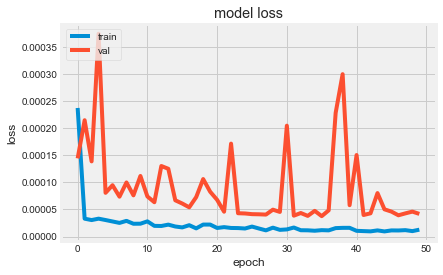

RMSE: 3.48335858168176


C:\Users\utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


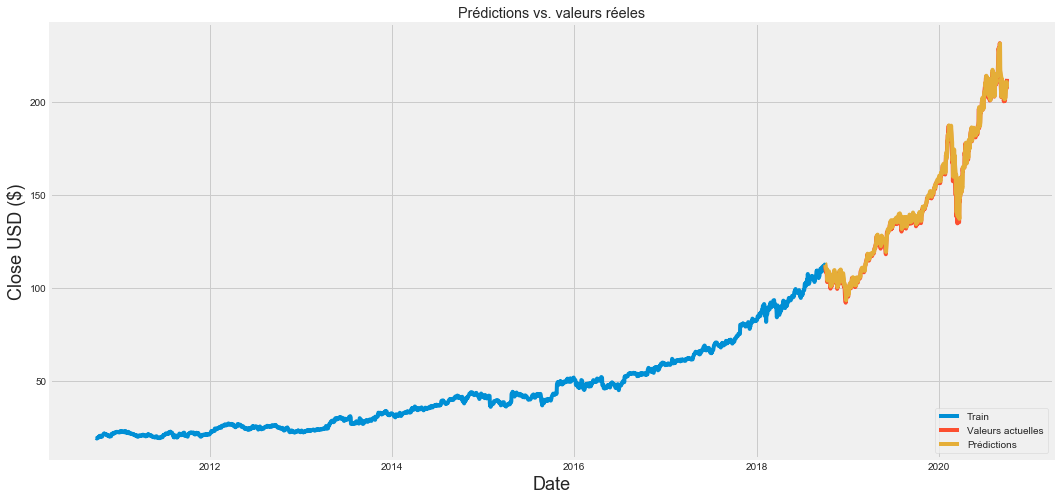

             Close  Predictions
Date                           
2018-10-03  112.11   112.916176
2018-10-04  109.80   112.837662
2018-10-05  109.15   110.672081
2018-10-08  107.91   109.857269
2018-10-09  109.28   108.789993
...            ...          ...
2020-09-25  207.82   204.071091
2020-09-28  209.44   209.115891
2020-09-29  207.26   210.768997
2020-09-30  210.33   208.113022
2020-10-01  212.46   210.891754

[503 rows x 2 columns]


In [10]:
model = algo_lstm(x_train, y_train, x_test, y_test, scaler, "MSFT")

# LSTM Google 

Longueur du data: 2016
Longueur du data: 2016
Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: 0.0028
Epoch 00001: val_loss improved from inf to 0.00110, saving model to GOOG_model.h5
110/110 [==============================] - 14s 128ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: 1.5692e-04
Epoch 00002: val_loss improved from 0.00110 to 0.00067, saving model to GOOG_model.h5
110/110 [==============================] - 9s 86ms/step - loss: 1.5692e-04 - val_loss: 6.7422e-04
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: 1.5683e-04
Epoch 00003: val_loss did not improve from 0.00067
110/110 [==============================] - 11s 97ms/step - loss: 1.5683e-04 - val_loss: 6.7514e-04
Epoch 4/50
110/110 [==============================] - ETA: 0s - loss: 1.5640e-04
Epoch 00004: val_loss improved from 0.00067 to 0.00062, saving model to GOOG_model.h5
110/110 [==============================]

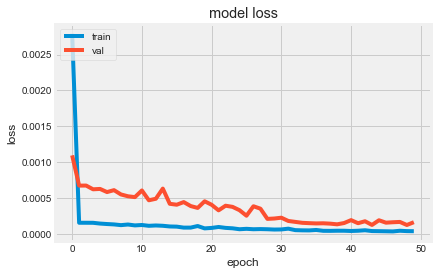

RMSE: 28.550383169979753


C:\Users\utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


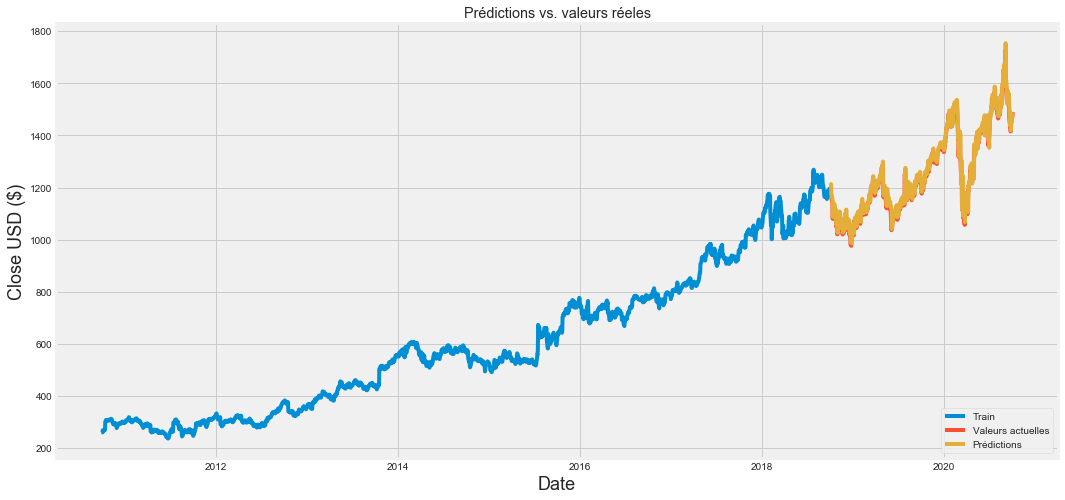

              Close  Predictions
Date                            
2018-10-03  1202.95  1210.371094
2018-10-04  1168.19  1213.218384
2018-10-05  1157.35  1173.404419
2018-10-08  1148.97  1164.086304
2018-10-09  1138.82  1158.045776
...             ...          ...
2020-09-25  1444.96  1443.533447
2020-09-28  1464.52  1462.219849
2020-09-29  1469.33  1482.468750
2020-09-30  1469.60  1482.532837
2020-10-01  1490.09  1479.753906

[503 rows x 2 columns]


In [11]:
x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len = split_data(df_concat, "GOOG")
model = algo_lstm(x_train, y_train, x_test, y_test, scaler, "GOOG")

# LSTM Amazon

Longueur du data: 2016
Longueur du data: 2016
Epoch 1/50
109/110 [============================>.] - ETA: 0s - loss: 5.0942e-04
Epoch 00001: val_loss improved from inf to 0.00037, saving model to AMZN_model.h5
110/110 [==============================] - 9s 78ms/step - loss: 5.0532e-04 - val_loss: 3.6755e-04
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: 3.8422e-05- ETA: 1s
Epoch 00002: val_loss improved from 0.00037 to 0.00025, saving model to AMZN_model.h5
110/110 [==============================] - 6s 53ms/step - loss: 3.8422e-05 - val_loss: 2.4627e-04
Epoch 3/50
109/110 [============================>.] - ETA: 0s - loss: 3.9836e-05
Epoch 00003: val_loss did not improve from 0.00025
110/110 [==============================] - 6s 54ms/step - loss: 4.0001e-05 - val_loss: 2.4708e-04
Epoch 4/50
110/110 [==============================] - ETA: 0s - loss: 3.7877e-05
Epoch 00004: val_loss did not improve from 0.00025
110/110 [==============================] - 7s 61ms/step -

110/110 [==============================] - ETA: 0s - loss: 1.5561e-05
Epoch 00034: val_loss did not improve from 0.00008
110/110 [==============================] - 4s 37ms/step - loss: 1.5561e-05 - val_loss: 8.5388e-05
Epoch 35/50
110/110 [==============================] - ETA: 0s - loss: 1.3656e-05
Epoch 00035: val_loss improved from 0.00008 to 0.00007, saving model to AMZN_model.h5
110/110 [==============================] - 4s 41ms/step - loss: 1.3656e-05 - val_loss: 7.3023e-05
Epoch 36/50
109/110 [============================>.] - ETA: 0s - loss: 1.3423e-05
Epoch 00036: val_loss improved from 0.00007 to 0.00007, saving model to AMZN_model.h5
110/110 [==============================] - 4s 40ms/step - loss: 1.3477e-05 - val_loss: 6.9708e-05
Epoch 37/50
110/110 [==============================] - ETA: 0s - loss: 1.4351e-05
Epoch 00037: val_loss did not improve from 0.00007
110/110 [==============================] - 4s 40ms/step - loss: 1.4351e-05 - val_loss: 1.3807e-04
Epoch 38/50
109/11

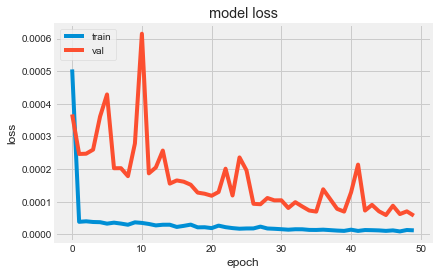

RMSE: 47.526110135753704


C:\Users\utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


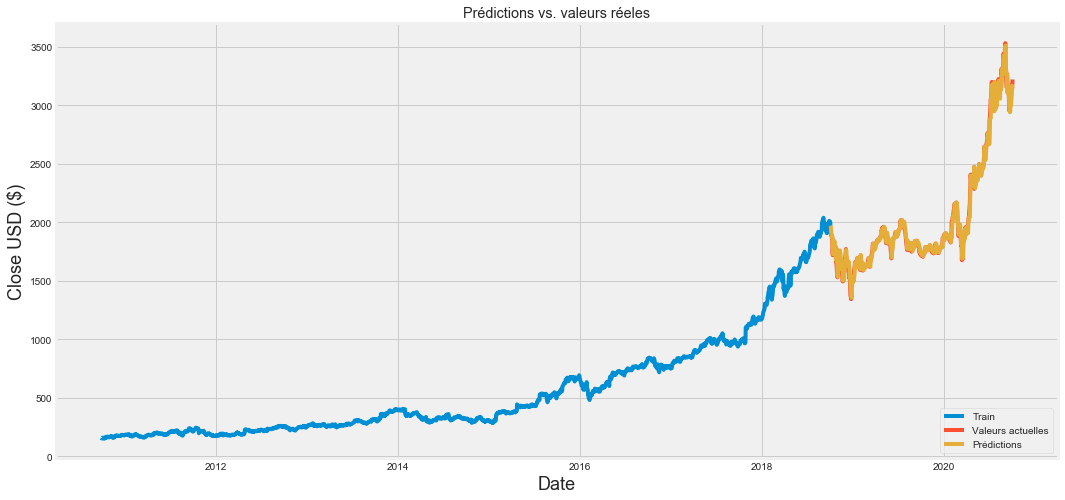

              Close  Predictions
Date                            
2018-10-03  1952.76  1971.870850
2018-10-04  1909.42  1952.028687
2018-10-05  1889.65  1911.289429
2018-10-08  1864.42  1891.817993
2018-10-09  1870.32  1869.599243
...             ...          ...
2020-09-25  3095.13  3008.826660
2020-09-28  3174.05  3086.971924
2020-09-29  3144.88  3169.153320
2020-09-30  3148.73  3133.898682
2020-10-01  3221.26  3131.387939

[503 rows x 2 columns]


In [12]:
x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len = split_data(df_concat, "AMZN")
model = algo_lstm(x_train, y_train, x_test, y_test, scaler, "AMZN")

# Prédiction du Prix du lendemain (le 02/10/2020)

1. convertir les données en un array qui ne contient que le prix de clôture.
2. Prénons le dernier prix de clôture de 60 jours pour faire la prédiction du 61ème jour.
3. Comparons la valaur prédite à la valeur actuelle sur le marché. 

In [13]:
def predict_price(symbol):
    tickerData = yf.Ticker(symbol)
    df = tickerData.history(period='1d', start='2010-10-1', end="2020-9-30")
    new_df = df.filter(['Close'])
    last_60_days = new_df[-60:].values
    scaler =  MinMaxScaler()

    last_60_days_scaled = scaler.fit_transform(last_60_days)
    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    print(f'Prix prédit: {pred_price}')

    actual_price = tickerData.history(period='1d', start="2020-10-03", end="2020-10-03")
    actual_price = actual_price.Close.values
    actual_price = np.array(actual_price)
    print(f'Prix réel: {actual_price}')
    return pred_price, actual_price

In [14]:
predict_price("MSFT")

Prix prédit: [[207.5695]]
Prix réel: [206.19]


(array([[207.5695]], dtype=float32), array([206.19]))

In [15]:
predict_price("AMZN")

Prix prédit: [[3149.5984]]
Prix réel: [3125.]


(array([[3149.5984]], dtype=float32), array([3125.]))

In [16]:
predict_price("GOOG")

Prix prédit: [[1471.2275]]
Prix réel: [1458.42]


(array([[1471.2275]], dtype=float32), array([1458.42]))

## Regression Linearire

In [17]:
df_concat

,Open,High,Low,Close,Volume,companies
Date,,,,,,
2010-09-30,19.50,19.67,19.30,19.40,61262700,MSFT
2010-10-01,19.62,19.66,19.25,19.32,62672300,MSFT
2010-10-04,18.98,19.01,18.84,18.94,98143400,MSFT
2010-10-05,19.06,19.37,18.94,19.29,78152900,MSFT
2010-10-06,19.27,19.44,19.12,19.36,50489700,MSFT
...,...,...,...,...,...,...
2020-09-25,1432.63,1450.00,1413.34,1444.96,1323000,GOOG
2020-09-28,1474.21,1476.80,1449.30,1464.52,2007900,GOOG
2020-09-29,1470.39,1476.66,1458.81,1469.33,978200,GOOG


In [18]:
df = df_concat.reset_index("Date")

In [19]:
df.head()

,Date,Open,High,Low,Close,Volume,companies
0,2010-09-30,19.50,19.67,19.30,19.40,61262700,MSFT
1,2010-10-01,19.62,19.66,19.25,19.32,62672300,MSFT
2,2010-10-04,18.98,19.01,18.84,18.94,98143400,MSFT
3,2010-10-05,19.06,19.37,18.94,19.29,78152900,MSFT
4,2010-10-06,19.27,19.44,19.12,19.36,50489700,MSFT


In [20]:
data = df.loc[df['companies']== "MSFT"]
data.head()

,Date,Open,High,Low,Close,Volume,companies
0,2010-09-30,19.50,19.67,19.30,19.40,61262700,MSFT
1,2010-10-01,19.62,19.66,19.25,19.32,62672300,MSFT
2,2010-10-04,18.98,19.01,18.84,18.94,98143400,MSFT
3,2010-10-05,19.06,19.37,18.94,19.29,78152900,MSFT
4,2010-10-06,19.27,19.44,19.12,19.36,50489700,MSFT


In [21]:
X = data.drop(['Date', 'companies', 'Close', 'Volume'], axis=1)

In [22]:
 y = data.Close

In [23]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)
score = model.score(X_test, y_test)
score

0.9998245885486993

In [25]:
 y_pred = model.predict(X_test)

In [26]:
rmse = mean_squared_error(y_test, y_pred)
rmse

0.3935885939984449

# Algo Strategies 

In [13]:
def moyenne_mobile(symbol, df_price):
    # 30 jours 
    SMA30 = pd.DataFrame()
    SMA30["Close Price"] = df_price["Close"].rolling(30).mean()

    # 100 jours 

    SMA100 = pd.DataFrame()
    SMA100["Close Price"] = df_price["Close"].rolling(100).mean()
    
    #Create a new dataframe to store all the datasets
    data =pd.DataFrame()
    data[symbol] =  df_price["Close"]
    data['SMA30'] = SMA30["Close Price"]
    data['SMA100'] = SMA100["Close Price"]
    
    return data
    

    

In [14]:
def signal(data, symbol, df_price):
    sigPriceBuy = []
    sigPriceSell= []
    flag = -1
    
    for i in range(len(data)):
        if data['SMA30'][i] > data['SMA100'][i]:
            if flag != 1:
                sigPriceBuy.append(data[symbol][i])
                sigPriceSell.append(np.nan)
                flag = 1
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif data['SMA30'][i] < data['SMA100'][i]:
            if flag != 0:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data[symbol][i])
                flag = 0
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
            
    return(sigPriceBuy,sigPriceSell)

In [15]:
pf = 1000
nb_action = 1
def porto(data):
    buy_sell = data[(data['Buy_Signal_Price'] > 0) | (data['Sell_Signal_Price'] > 0)]
    sell =buy_sell['Sell_Signal_Price'].sum()
    buy = buy_sell['Buy_Signal_Price'].sum()
    gain_perte = ((sell*1.01) - (buy*1.01))* nb_action
    pf_final = pf + gain_perte
    return pf_final

In [7]:
data_f = moyenne_mobile("MSFT", msft)
signal_f = signal(data_f, "MSFT", msft)
data_f['Buy_Signal_Price'] = signal_f[0]
data_f['Sell_Signal_Price']= signal_f[1]

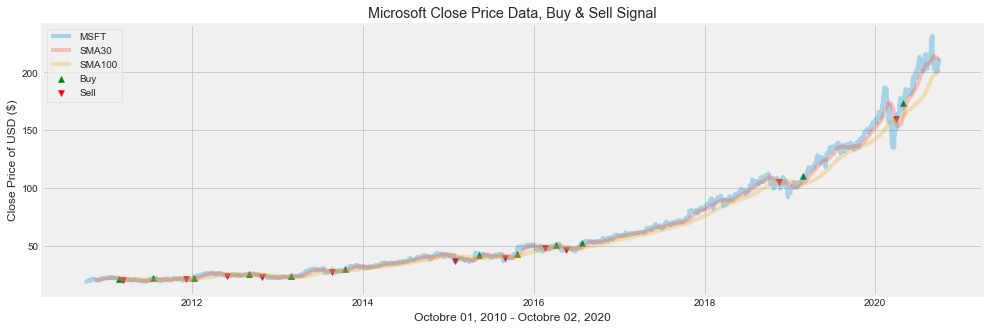

In [8]:
plt.figure(figsize=(15,5))
plt.plot(data_f['MSFT'],label = 'MSFT', alpha = 0.30)
plt.plot(data_f['SMA30'], label = 'SMA30', alpha = 0.30)
plt.plot(data_f['SMA100'], label = 'SMA100', alpha = 0.30)
plt.scatter(data_f.index,data_f['Buy_Signal_Price'], label = 'Buy', marker = '^', color = 'green')
plt.scatter(data_f.index,data_f['Sell_Signal_Price'], label = 'Sell', marker = 'v', color = 'red')
plt.title('Microsoft Close Price Data, Buy & Sell Signal')
plt.xlabel('Octobre 01, 2010 - Octobre 02, 2020')
plt.ylabel('Close Price of USD ($)')
plt.legend(loc='upper left', fontsize=10)
plt.show()


## Amazon 

In [16]:
data_z = moyenne_mobile("AMZN", amzn)

signal_z = signal(data_z, "AMZN", amzn)

data_z['Buy_Signal_Price'] = signal_z[0]
data_z['Sell_Signal_Price']= signal_z[1]


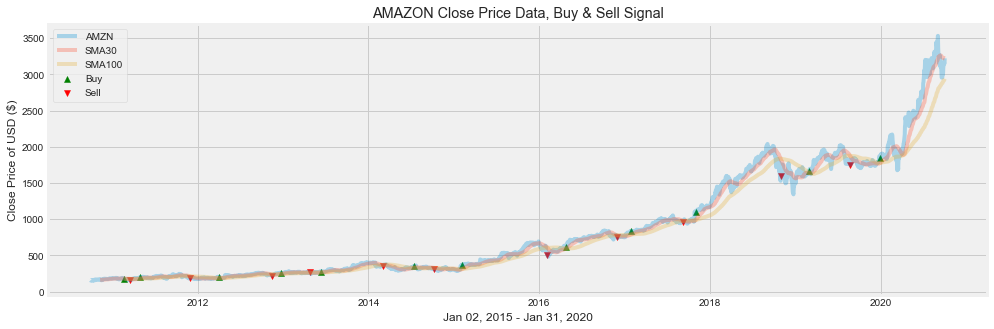

In [17]:
plt.figure(figsize=(15,5))
plt.plot(data_z['AMZN'],label = 'AMZN', alpha = 0.30)
plt.plot(data_z['SMA30'], label = 'SMA30', alpha = 0.30)
plt.plot(data_z['SMA100'], label = 'SMA100', alpha = 0.30)
plt.scatter(data_z.index,data_z['Buy_Signal_Price'], label = 'Buy', marker = '^', color = 'green')
plt.scatter(data_z.index,data_z['Sell_Signal_Price'], label = 'Sell', marker = 'v', color = 'red')
plt.title('AMAZON Close Price Data, Buy & Sell Signal')
plt.xlabel('Jan 02, 2015 - Jan 31, 2020')
plt.ylabel('Close Price of USD ($)')
plt.legend(loc='upper left', fontsize=10)
plt.show()

## Google

In [97]:
signal_g = signal(data_goog, "GOOG", goog)

data_goog['Buy_Signal_Price'] = signal_g[0]
data_goog['Sell_Signal_Price']= signal_g[1]


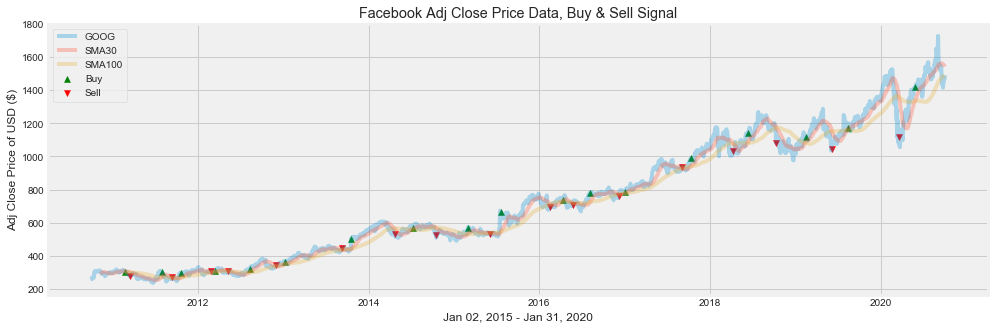

In [98]:
plt.figure(figsize=(15,5))
plt.plot(data_goog['GOOG'],label = 'GOOG', alpha = 0.30)
plt.plot(data_goog['SMA30'], label = 'SMA30', alpha = 0.30)
plt.plot(data_goog['SMA100'], label = 'SMA100', alpha = 0.30)
plt.scatter(data_goog.index,data_goog['Buy_Signal_Price'], label = 'Buy', marker = '^', color = 'green')
plt.scatter(data_goog.index,data_goog['Sell_Signal_Price'], label = 'Sell', marker = 'v', color = 'red')
plt.title('Google Close Price Data, Buy & Sell Signal')
plt.xlabel('Jan 02, 2015 - Jan 31, 2020')
plt.ylabel('Adj Close Price of USD ($)')
plt.legend(loc='upper left', fontsize=10)
plt.show()

## Conclusion

La RMSE de Microsoft est plus faible,  ce qui signifie que l'écart entre nos valeurs prédites et nos valeurs réelles est faible. 

Nous avons fait la prédiction d'un pas dans l'avenir(le 02/10/2020), après visualisation de nos resultats, notre modèle LSTM est assez bon pour prédir correctement les cours des actions. 